# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [58]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [59]:
time0 = time.time()

with open('../input/kp102-ds59/LCLoans_59_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)

df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
display(df.head())
df.drop(columns = ['mths_since_last_record', 'mths_since_last_delinq',
                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(200000)
display(df.shape, time.time()-time0, df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,5000,5000,4975.0,36,10.65,162.869995,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,739,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1076863,10000,10000,10000.0,36,13.49,339.309998,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,other,personel,917xx,CA,20.00,0.0,Feb-1996,694,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1075269,5000,5000,5000.0,36,7.90,156.460007,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,734,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1072053,3000,3000,3000.0,36,18.64,109.430000,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,664,2.0,NaN,NaN,4.0,0.0,8221,87.5,4.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1071570,5375,5375,5350.0,60,12.69,121.449997,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,Dec-2011,Charged Off,other,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,729,0.0,NaN,NaN,2.0,0.0,9279,36.5,3.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0


(100000, 36)

0.48752856254577637

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
160891678,13825,13825,13825.0,36,8.19,434.440002,A,A4,Owner,10+ years,MORTGAGE,180000.0,Not Verified,Oct-2019,Current,debt_consolidation,Debt consolidation,496xx,MI,10.210000,3.0,May-2006,729,0.0,17.0,0.0,7266,9.9,33.0,w,Individual,NaN,NaN,NaN,3.0,0.0
79084383,9000,9000,9000.0,36,15.31,313.359985,C,C5,combo,10+ years,MORTGAGE,62000.0,Source Verified,May-2016,Fully Paid,debt_consolidation,Debt consolidation,531xx,WI,37.709999,0.0,May-1999,714,0.0,12.0,0.0,33854,60.9,19.0,w,Individual,NaN,NaN,NaN,2.0,0.0
125278953,20000,20000,20000.0,36,7.97,626.460022,A,A5,assistant manager,3 years,MORTGAGE,47500.0,Verified,Dec-2017,Fully Paid,debt_consolidation,Debt consolidation,816xx,CO,43.380001,0.0,Sep-2008,729,0.0,9.0,0.0,5074,45.7,16.0,w,Joint App,107500.0,20.6,Verified,2.0,0.0
94218835,19600,19600,19600.0,60,13.49,450.899994,C,C2,Teacher,10+ years,MORTGAGE,101000.0,Verified,Dec-2016,Current,home_improvement,Home improvement,960xx,CA,25.610001,0.0,May-2002,694,0.0,8.0,1.0,1810,86.2,19.0,w,Individual,NaN,NaN,NaN,0.0,1.0
57195314,17000,17000,17000.0,36,6.24,519.030029,A,A2,chief of staff,2 years,OWN,75000.0,Not Verified,Aug-2015,Fully Paid,credit_card,Credit card refinancing,330xx,FL,14.590000,0.0,Dec-1998,764,2.0,12.0,0.0,16834,28.8,30.0,w,Individual,NaN,NaN,NaN,4.0,0.0


In [89]:
### feature decription:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc


,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
5,annual_inc_joint,The combined self-reported annual income provi...
6,application_type,Indicates whether the loan is an individual ap...
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/...


In [61]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,years_borrowing
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
160891678,13825,13825,13825.0,36,8.19,434.440002,A,A4,Owner,10+ years,MORTGAGE,180000.0,Not Verified,2019-10-01,Current,debt_consolidation,Debt consolidation,496xx,MI,10.210000,3.0,2006-05-01,729,0.0,17.0,0.0,7266,9.9,33.0,w,Individual,NaN,NaN,NaN,3.0,0.0,2019,10,13.418482
79084383,9000,9000,9000.0,36,15.31,313.359985,C,C5,combo,10+ years,MORTGAGE,62000.0,Source Verified,2016-05-01,Fully Paid,debt_consolidation,Debt consolidation,531xx,WI,37.709999,0.0,1999-05-01,714,0.0,12.0,0.0,33854,60.9,19.0,w,Individual,NaN,NaN,NaN,2.0,0.0,2016,5,17.002403
125278953,20000,20000,20000.0,36,7.97,626.460022,A,A5,assistant manager,3 years,MORTGAGE,47500.0,Verified,2017-12-01,Fully Paid,debt_consolidation,Debt consolidation,816xx,CO,43.380001,0.0,2008-09-01,729,0.0,9.0,0.0,5074,45.7,16.0,w,Joint App,107500.0,20.6,Verified,2.0,0.0,2017,12,9.248650
94218835,19600,19600,19600.0,60,13.49,450.899994,C,C2,Teacher,10+ years,MORTGAGE,101000.0,Verified,2016-12-01,Current,home_improvement,Home improvement,960xx,CA,25.610001,0.0,2002-05-01,694,0.0,8.0,1.0,1810,86.2,19.0,w,Individual,NaN,NaN,NaN,0.0,1.0,2016,12,14.587569
57195314,17000,17000,17000.0,36,6.24,519.030029,A,A2,chief of staff,2 years,OWN,75000.0,Not Verified,2015-08-01,Fully Paid,credit_card,Credit card refinancing,330xx,FL,14.590000,0.0,1998-12-01,764,2.0,12.0,0.0,16834,28.8,30.0,w,Individual,NaN,NaN,NaN,4.0,0.0,2015,8,16.665640


In [62]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             51238
Current                                                35162
Charged Off                                            12454
Late (31-120 days)                                       542
In Grace Period                                          338
Issued                                                    77
Late (16-30 days)                                         77
Does not meet the credit policy. Status:Fully Paid        60
Does not meet the credit policy. Status:Charged Off       32
Default                                                   20
Name: loan_status, dtype: int64

(64346, 40)

Fully Paid                                             51238
Charged Off                                            12454
Late (31-120 days)                                       542
Does not meet the credit policy. Status:Fully Paid        60
Does not meet the credit policy. Status:Charged Off       32
Default                                                   20
Current                                                    0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Name: loan_status, dtype: int64

loan_amnt                    64346
funded_amnt                  64346
funded_amnt_inv              64346
term                         64346
int_rate                     64346
installment                  64346
grade                        64346
sub_grade                    64346
emp_title                    59755
emp_length                   60256
home_ownership               64346
annual_inc                   64346
verification_status          64346
issue_d                      64346
loan_status                  64346
purpose                      64346
title                        63582
zip_code                     64346
addr_state                   64346
dti                          64306
delinq_2yrs                  64345
earliest_cr_line             64345
fico_range_high              64346
inq_last_6mths               64345
open_acc                     64345
pub_rec                      64345
revol_bal                    64346
revol_util                   64295
total_acc           

30.478209495544434

### Feature Preprocessing

In [63]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=2
df.loc[df.revol_util>100,'revol_util']=100

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

10.0    21036
2.0      5743
0.0      5342
3.0      5282
1.0      4191
5.0      3921
4.0      3868
6.0      3052
8.0      2765
7.0      2697
9.0      2359
Name: emp_length, dtype: int64

In [64]:
df.target.mean()

0.20277872750442918

In [65]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [66]:
df.application_type.value_counts()

Individual    61877
Joint App      2469
Name: application_type, dtype: int64

### EDA

In [67]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,64346.000000,64346.000000,64346.000000
mean,14628.988593,14623.017748,14603.470703
std,8999.732110,8997.354444,9001.176758
min,500.000000,500.000000,0.000000
25%,8000.000000,8000.000000,7928.282104
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36    48091
60    16255
Name: term, dtype: int64

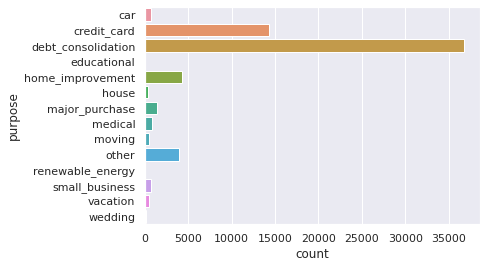

<AxesSubplot:xlabel='count', ylabel='emp_length'>

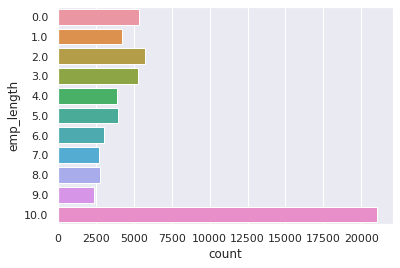

In [68]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [69]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [70]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    13048.000000
mean         0.333614
std          0.887682
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         14.000000
Name: delinq_2yrs, dtype: float64

count    51297.000000
mean         0.308361
std          0.861968
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: delinq_2yrs, dtype: float64

In [71]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

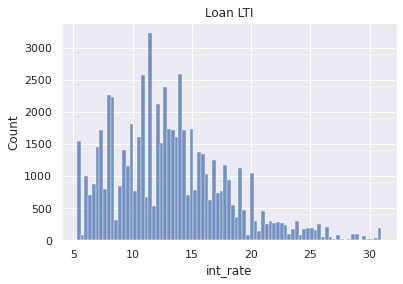

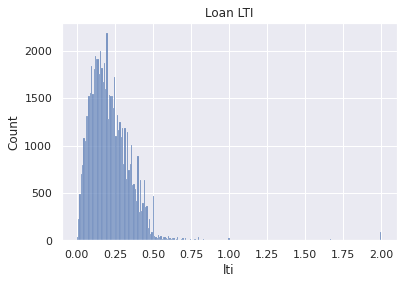

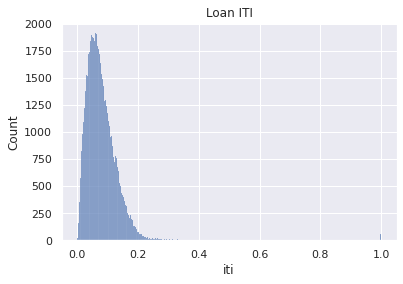

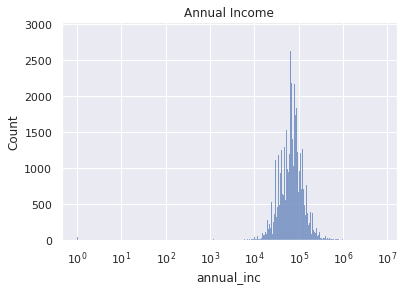

In [72]:
sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

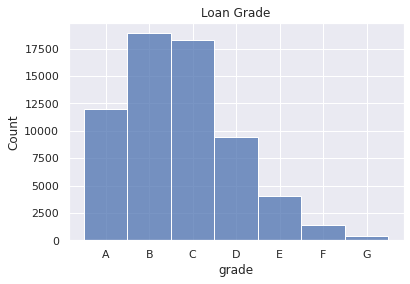

In [73]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

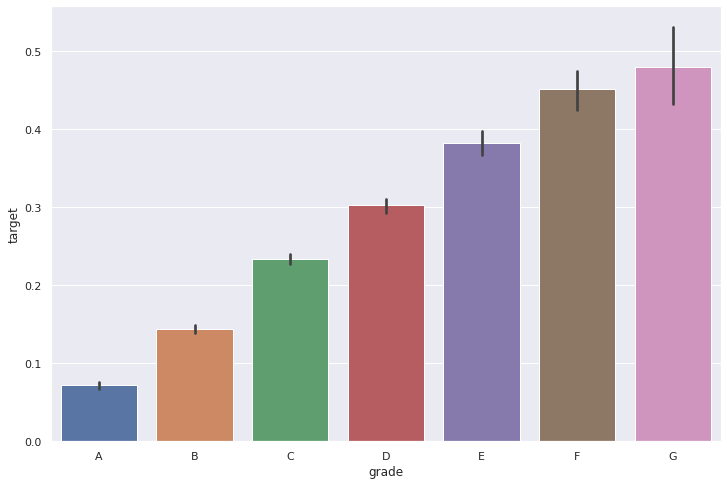

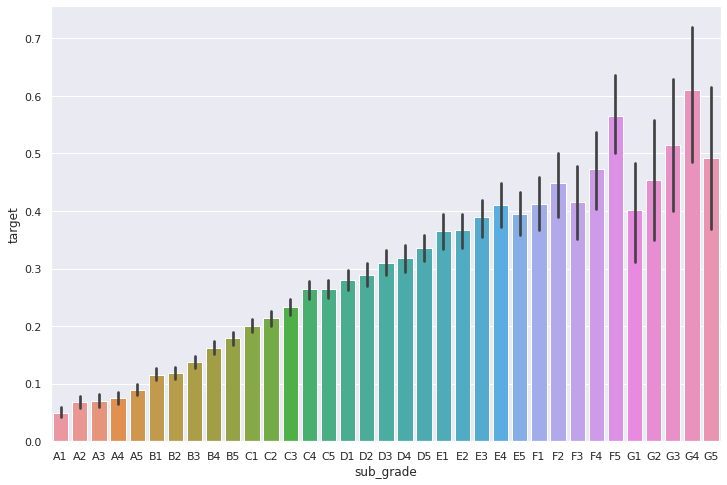

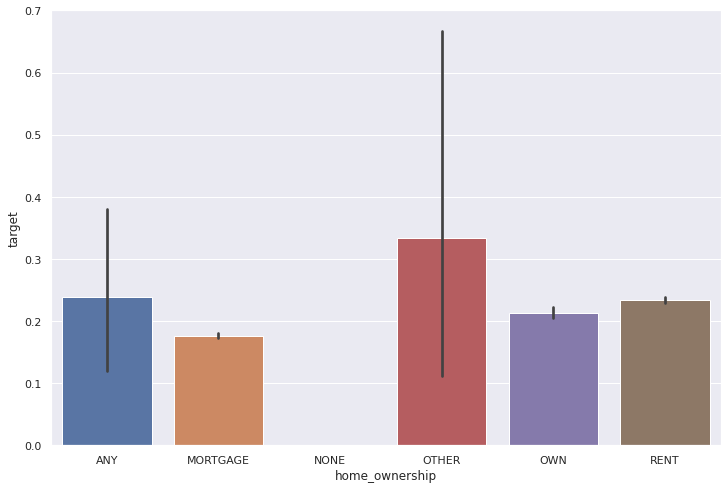

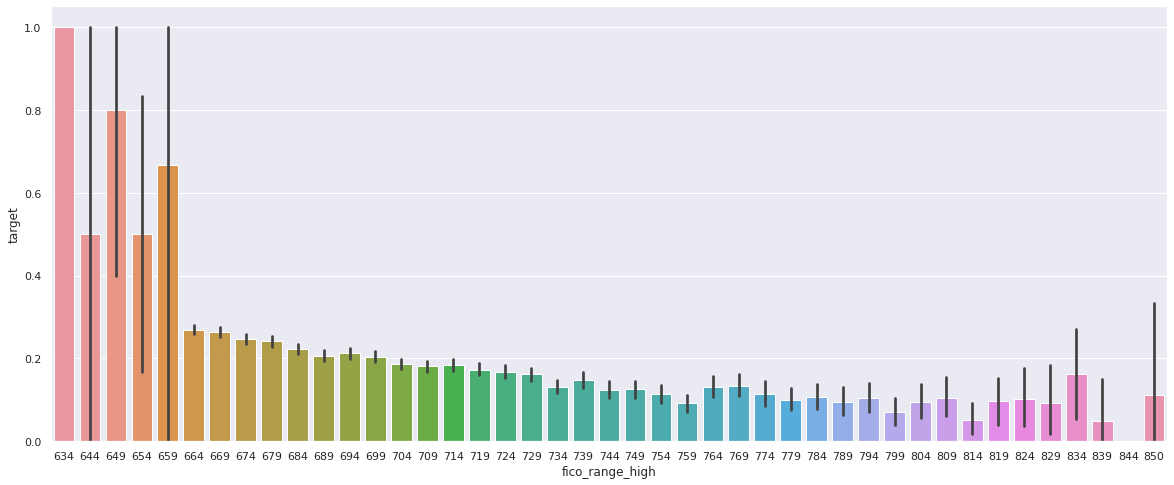

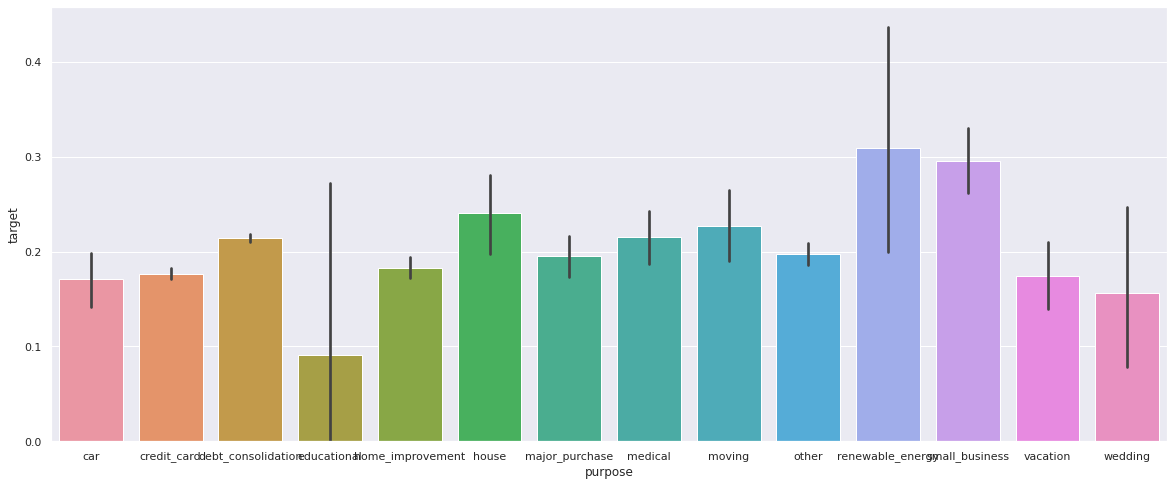

In [91]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
#sns.barplot(x='int_rate', y='target', data=df)
#plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()

### Train-test split, missing values

In [75]:
display(df.count())

loan_amnt               64346
funded_amnt             64346
funded_amnt_inv         64346
term                    64346
int_rate                64346
installment             64346
grade                   64346
sub_grade               64346
emp_title               59755
emp_length              60256
home_ownership          64346
annual_inc              64346
verification_status     64346
purpose                 64346
title                   63582
zip_code                64346
addr_state              64346
dti                     64306
delinq_2yrs             64345
fico_range_high         64346
inq_last_6mths          64345
open_acc                64345
pub_rec                 64345
revol_bal               64346
revol_util              64295
total_acc               64345
initial_list_status     64346
application_type        64346
mort_acc                62612
pub_rec_bankruptcies    64304
year_issued             64346
month_issued            64346
years_borrowing         64345
target    

In [76]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(57912, 37)

(6434, 37)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,years_borrowing,target,lti,iti,joint
0,9000,9000,9000.0,36,15.31,313.359985,C,C5,combo,10.0,MORTGAGE,62000.0,Source Verified,debt_consolidation,Debt consolidation,531,WI,37.709999,0.0,714,0.0,12.0,0.0,33854,60.9,19.0,w,Individual,2.0,0.0,2016,5,17.002403,0.0,0.145161,0.060650,0
1,20000,20000,20000.0,36,7.97,626.460022,A,A5,assistant manager,3.0,MORTGAGE,47500.0,Verified,debt_consolidation,Debt consolidation,816,CO,43.380001,0.0,729,0.0,9.0,0.0,5074,45.7,16.0,w,Joint App,2.0,0.0,2017,12,9.248650,0.0,0.421053,0.158264,1
2,17000,17000,17000.0,36,6.24,519.030029,A,A2,chief of staff,2.0,OWN,75000.0,Not Verified,credit_card,Credit card refinancing,330,FL,14.590000,0.0,764,2.0,12.0,0.0,16834,28.8,30.0,w,Individual,4.0,0.0,2015,8,16.665640,0.0,0.226667,0.083045,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,years_borrowing,target,lti,iti,joint
36756,34700,34700,34700.0,60,16.99,862.200012,D,D1,Sr. Risk Control Specialists,10.0,RENT,115000.0,Verified,debt_consolidation,Debt consolidation,354,AL,16.690001,0.0,724,1.0,8.0,0.0,17191,43.6,12.0,w,Individual,0.0,0.0,2017,4,22.582257,0.0,0.301739,0.089969,0
3780,8000,8000,8000.0,36,10.75,260.970001,B,B4,Clerk,10.0,MORTGAGE,52000.0,Source Verified,home_improvement,Home improvement,945,CA,21.260000,0.0,724,1.0,10.0,0.0,21733,80.2,16.0,w,Individual,3.0,0.0,2016,6,17.500702,0.0,0.153846,0.060224,0
8537,10000,10000,10000.0,36,9.93,322.350006,B,B2,General Manager,0.0,MORTGAGE,70000.0,Not Verified,debt_consolidation,Debt consolidation,920,CA,15.500000,0.0,674,0.0,9.0,0.0,8526,56.1,17.0,w,Individual,1.0,0.0,2017,10,21.251634,0.0,0.142857,0.055260,0


loan_amnt               57912
funded_amnt             57912
funded_amnt_inv         57912
term                    57912
int_rate                57912
installment             57912
grade                   57912
sub_grade               57912
emp_title               57912
emp_length              57912
home_ownership          57912
annual_inc              57912
verification_status     57912
purpose                 57912
title                   57912
zip_code                57912
addr_state              57912
dti                     57912
delinq_2yrs             57912
fico_range_high         57912
inq_last_6mths          57912
open_acc                57912
pub_rec                 57912
revol_bal               57912
revol_util              57912
total_acc               57912
initial_list_status     57912
application_type        57912
mort_acc                57912
pub_rec_bankruptcies    57912
year_issued             57912
month_issued            57912
years_borrowing         57911
target    

loan_amnt               6434
funded_amnt             6434
funded_amnt_inv         6434
term                    6434
int_rate                6434
installment             6434
grade                   6434
sub_grade               6434
emp_title               6434
emp_length              6434
home_ownership          6434
annual_inc              6434
verification_status     6434
purpose                 6434
title                   6434
zip_code                6434
addr_state              6434
dti                     6434
delinq_2yrs             6434
fico_range_high         6434
inq_last_6mths          6434
open_acc                6434
pub_rec                 6434
revol_bal               6434
revol_util              6434
total_acc               6434
initial_list_status     6434
application_type        6434
mort_acc                6434
pub_rec_bankruptcies    6434
year_issued             6434
month_issued            6434
years_borrowing         6434
target                  6434
lti           

### Categorical features encoding

In [77]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

11.539701223373413

1.6952414512634277

(57912, 37)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,years_borrowing,target,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,9000,9000,9000.0,36,15.31,313.359985,10.0,62000.0,Source Verified,37.709999,0.0,714,0.0,12.0,0.0,33854,60.9,19.0,w,Individual,2.0,0.0,2016,5,17.002403,0.0,0.145161,0.060650,0,0.232696,0.259598,0.202883,0.178336,0.212714,0.217690,0.162860,0.201150
1,20000,20000,20000.0,36,7.97,626.460022,3.0,47500.0,Verified,43.380001,0.0,729,0.0,9.0,0.0,5074,45.7,16.0,w,Joint App,2.0,0.0,2017,12,9.248650,0.0,0.421053,0.158264,1,0.074603,0.094165,0.112713,0.178336,0.212714,0.217690,0.122086,0.156683
2,17000,17000,17000.0,36,6.24,519.030029,2.0,75000.0,Not Verified,14.590000,0.0,764,2.0,12.0,0.0,16834,28.8,30.0,w,Individual,4.0,0.0,2015,8,16.665640,0.0,0.226667,0.083045,0,0.074603,0.060300,0.202883,0.208296,0.179112,0.182743,0.282438,0.223295
3,21000,21000,21000.0,36,14.08,718.549988,10.0,160000.0,Source Verified,16.600000,0.0,669,1.0,15.0,0.0,14314,68.0,20.0,w,Individual,3.0,0.0,2017,10,14.420556,0.0,0.131250,0.053891,0,0.232696,0.234534,0.202883,0.178336,0.212714,0.217690,0.217308,0.223295
4,15000,15000,15000.0,36,7.96,469.769989,5.0,38000.0,Source Verified,27.920000,0.0,739,0.0,16.0,0.0,17014,45.9,27.0,w,Joint App,1.0,0.0,2018,3,10.749023,0.0,0.394737,0.148348,1,0.074603,0.094165,0.202883,0.178336,0.198755,0.210827,0.208063,0.215279


loan_amnt                 57912
funded_amnt               57912
funded_amnt_inv           57912
term                      57912
int_rate                  57912
installment               57912
emp_length                57912
annual_inc                57912
verification_status       57912
dti                       57912
delinq_2yrs               57912
fico_range_high           57912
inq_last_6mths            57912
open_acc                  57912
pub_rec                   57912
revol_bal                 57912
revol_util                57912
total_acc                 57912
initial_list_status       57912
application_type          57912
mort_acc                  57912
pub_rec_bankruptcies      57912
year_issued               57912
month_issued              57912
years_borrowing           57911
target                    57912
lti                       57912
iti                       57912
joint                     57912
grade_encoded             57912
sub_grade_encoded         57912
emp_titl

In [78]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,years_borrowing,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
36756,34700,34700,34700.0,60,16.99,862.200012,10.0,115000.0,Verified,16.690001,0.0,724,1.0,8.0,0.0,17191,43.6,12.0,w,Individual,0.0,0.0,2017,4,22.582257,0.301739,0.089969,0,0.303055,0.284589,0.203533,0.234185,0.214599,0.219724,0.226584,0.216869
3780,8000,8000,8000.0,36,10.75,260.970001,10.0,52000.0,Source Verified,21.260000,0.0,724,1.0,10.0,0.0,21733,80.2,16.0,w,Individual,3.0,0.0,2016,6,17.500702,0.153846,0.060224,0,0.146111,0.165865,0.219605,0.177775,0.185507,0.187765,0.176003,0.208264
8537,10000,10000,10000.0,36,9.93,322.350006,0.0,70000.0,Not Verified,15.500000,0.0,674,0.0,9.0,0.0,8526,56.1,17.0,w,Individual,1.0,0.0,2017,10,21.251634,0.142857,0.055260,0,0.146111,0.118439,0.205970,0.177775,0.214599,0.219724,0.205576,0.208264
5748,6000,6000,6000.0,36,12.74,201.419998,10.0,80000.0,Verified,29.320000,0.0,684,0.0,25.0,0.0,17567,46.7,34.0,f,Individual,1.0,0.0,2017,1,21.673272,0.075000,0.030213,0,0.232972,0.202794,0.203533,0.177775,0.198595,0.202951,0.175681,0.188132
38051,24625,24625,24625.0,36,17.10,879.179993,10.0,54800.0,Source Verified,20.450001,0.0,674,1.0,12.0,1.0,10573,83.9,20.0,f,Individual,3.0,1.0,2013,10,21.166759,0.449361,0.192521,0,0.232972,0.261512,0.203533,0.177775,0.214599,0.203533,0.239544,0.191647


Number of features before transaformation:  (57912, 36)
time to do feature proprocessing:  1.8827459812164307
Number of features after transaformation:  (57912, 40)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__delinq_2yrs,remainder__fico_range_high,remainder__inq_last_6mths,remainder__open_acc,remainder__pub_rec,remainder__revol_bal,remainder__revol_util,remainder__total_acc,remainder__mort_acc,remainder__pub_rec_bankruptcies,remainder__year_issued,remainder__month_issued,remainder__years_borrowing,remainder__lti,remainder__iti,remainder__joint,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,9000.0,9000.0,9000.0,36.0,15.31,313.359985,10.0,62000.0,37.709999,0.0,714.0,0.0,12.0,0.0,33854.0,60.9,19.0,2.0,0.0,2016.0,5.0,17.002403,0.145161,0.060650,0.0,0.232696,0.259598,0.202883,0.178336,0.212714,0.217690,0.162860,0.201150
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,20000.0,20000.0,20000.0,36.0,7.97,626.460022,3.0,47500.0,43.380001,0.0,729.0,0.0,9.0,0.0,5074.0,45.7,16.0,2.0,0.0,2017.0,12.0,9.248650,0.421053,0.158264,1.0,0.074603,0.094165,0.112713,0.178336,0.212714,0.217690,0.122086,0.156683
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,17000.0,17000.0,17000.0,36.0,6.24,519.030029,2.0,75000.0,14.590000,0.0,764.0,2.0,12.0,0.0,16834.0,28.8,30.0,4.0,0.0,2015.0,8.0,16.665640,0.226667,0.083045,0.0,0.074603,0.060300,0.202883,0.208296,0.179112,0.182743,0.282438,0.223295
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,21000.0,21000.0,21000.0,36.0,14.08,718.549988,10.0,160000.0,16.600000,0.0,669.0,1.0,15.0,0.0,14314.0,68.0,20.0,3.0,0.0,2017.0,10.0,14.420556,0.131250,0.053891,0.0,0.232696,0.234534,0.202883,0.178336,0.212714,0.217690,0.217308,0.223295
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,15000.0,15000.0,15000.0,36.0,7.96,469.769989,5.0,38000.0,27.920000,0.0,739.0,0.0,16.0,0.0,17014.0,45.9,27.0,1.0,0.0,2018.0,3.0,10.749023,0.394737,0.148348,1.0,0.074603,0.094165,0.202883,0.178336,0.198755,0.210827,0.208063,0.215279


### Modeling

In [79]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8514642906478795

'F1 score: '

0.4552248258391387

'ROCAUC: '

0.6480224913626077

'PRAUC: '

0.7203972800248923

'R20P: '

0.9472837022132797

'Test Accuracy: '

0.7968604289710911

'F1 score: '

0.19370758790869833

'ROCAUC: '

0.542631071201304

'PRAUC: '

0.33967405570368486

'R20P: '

0.3984126984126984

1.351334571838379

In [80]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-11 22:37:28,038] A new study created in memory with name: no-name-dfe828fe-9fa3-4d70-8623-3a8785c3b1c5
[I 2022-08-11 22:37:43,319] Trial 0 finished with value: 0.5315091330465354 and parameters: {'n_estimators': 739, 'max_depth': 8, 'learning_rate': 0.19133176903226404, 'colsample_bytree': 0.7645911788825657, 'subsample': 0.5099348509518805, 'alpha': 6.315121466310678, 'lambda': 2.249768848396883, 'gamma': 3.125524766947211e-08, 'min_child_weight': 4.560659397482632}. Best is trial 0 with value: 0.5315091330465354.
[I 2022-08-11 22:37:46,851] Trial 1 finished with value: 0.5445579080163416 and parameters: {'n_estimators': 829, 'max_depth': 2, 'learning_rate': 0.29300092322488264, 'colsample_bytree': 0.6411328106716241, 'subsample': 0.8157730337166069, 'alpha': 0.291002895490472, 'lambda': 0.293202975521241, 'gamma': 2.3435206224592922e-05, 'min_child_weight': 1.5918920722153787}. Best is trial 1 with value: 0.5445579080163416.
[I 2022-08-11 22:37:49,830] Trial 2 finished wit

Total time for hypermarameter optimization  86.09307312965393
        n_estimators : 706
           max_depth : 3
       learning_rate : 0.3202521746669258
    colsample_bytree : 0.1718369111284856
           subsample : 0.6774981330763163
               alpha : 0.6301249660654051
              lambda : 0.3174073354403118
               gamma : 8.781414447733198e-05
    min_child_weight : 0.5492166631717236
best objective value : 0.5446736190690998


'Train Accuracy: '

0.8268925265920707

'F1 score: '

0.34728823491112704

'ROCAUC: '

0.6033228146483552

'PRAUC: '

0.5708121030699602

'R20P: '

0.7693311582381729

'Test Accuracy: '

0.7976375505129002

'F1 score: '

0.21471652593486126

'ROCAUC: '

0.5494113046252326

'PRAUC: '

0.3484920197077688

'R20P: '

0.42

89.293790102005

In [81]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

,col,FI
9,remainder__funded_amnt_inv,0.004041
14,remainder__annual_inc,0.003792
7,remainder__loan_amnt,0.003544
10,remainder__term,0.002922
21,remainder__revol_bal,0.002425
26,remainder__year_issued,0.002238
19,remainder__open_acc,0.001896
34,remainder__emp_title_encoded,0.001803
38,remainder__zip_code_encoded,0.001523
12,remainder__installment,0.001430


,col_name,feature_importance_vals
10,remainder__term,0.193882
11,remainder__int_rate,0.188031
26,remainder__year_issued,0.186903
33,remainder__sub_grade_encoded,0.157350
19,remainder__open_acc,0.131453
34,remainder__emp_title_encoded,0.130549
15,remainder__dti,0.116379
17,remainder__fico_range_high,0.116100
18,remainder__inq_last_6mths,0.115602
35,remainder__home_ownership_encoded,0.113561


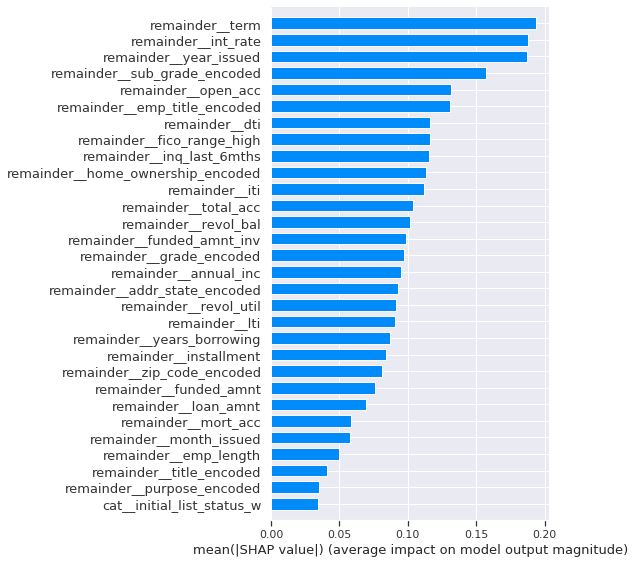

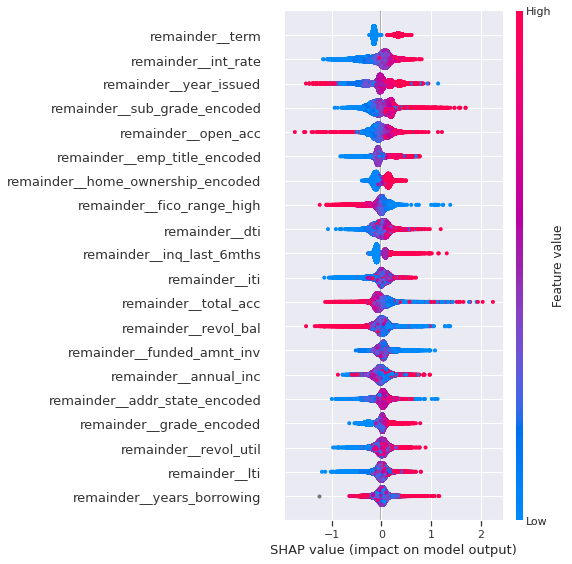

In [82]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [83]:
time.time()-time0

123.79869627952576